In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import f,t
import itertools

#  Détails, préparation et filtrage des données

Cet ensemble de données fournit une vue d'ensemble détaillée des routines d'exercice, des attributs physiques et des mesures de la condition physique des membres d'une salle de sport. Il contient 973 échantillons de données sur les salles de sport, y compris des indicateurs de performance clés tels que la fréquence cardiaque, les calories brûlées et la durée de l'entraînement. Chaque entrée comprend également des données démographiques et des niveaux d'expérience, ce qui permet une analyse complète des schémas de remise en forme, de la progression des athlètes et des tendances en matière de santé.
Ce jeu de données comporte 15 variables (ou colonnes) présentant à la fois des données continues et d'autres discrètes. Afin de mener à bien notre analyse, nous nous sommes restreints aux valeurs continues, celles discrètes étant peu exploitables ou peu intéressantes.
Nous avons ainsi sélectionné des variables tels que l'âge, le poids, l'IMC etc.. soit 10 variables en tout.

In [70]:
df = pd.read_csv("gym_members_exercise_tracking.csv")

# On garde uniquement les variables continues pour l'analyse (Calories_Burned incluse)
continuous_vars = [
    "Age", "Weight (kg)", "Height (m)", "Max_BPM", "Avg_BPM", "Resting_BPM",
    "Calories_Burned", "Fat_Percentage", "Water_Intake (liters)", "BMI"
]
df = df[continuous_vars]

df

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Calories_Burned,Fat_Percentage,Water_Intake (liters),BMI
0,56,88.3,1.71,180,157,60,1313.0,12.6,3.5,30.20
1,46,74.9,1.53,179,151,66,883.0,33.9,2.1,32.00
2,32,68.1,1.66,167,122,54,677.0,33.4,2.3,24.71
3,25,53.2,1.70,190,164,56,532.0,28.8,2.1,18.41
4,38,46.1,1.79,188,158,68,556.0,29.2,2.8,14.39
...,...,...,...,...,...,...,...,...,...,...
968,24,87.1,1.74,187,158,67,1364.0,10.0,3.5,28.77
969,25,66.6,1.61,184,166,56,1260.0,25.0,3.0,25.69
970,59,60.4,1.76,194,120,53,929.0,18.8,2.7,19.50
971,32,126.4,1.83,198,146,62,883.0,28.2,2.1,37.74


# Mise en place des différentes corrélations

Afin de représenter les différentes corrélations possibles entre les valeurs, nous avons affiché une matrice de corrélation qui a mis en avant d'importantes corrélations. On retrouve par exemple une corrélation de 0.85 entre la quantité d'eau bue en fonction du poids de la personne. D'autres liens comme la proportion de calories brûlées en fonction du pourcentage de graisse ont pu être mis en avant.

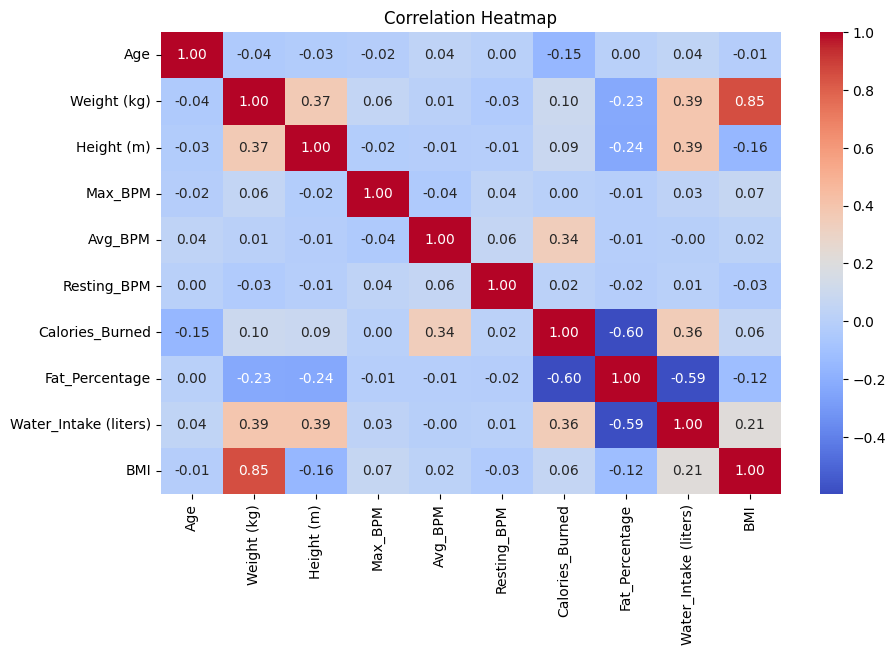

In [71]:
# Compute the correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

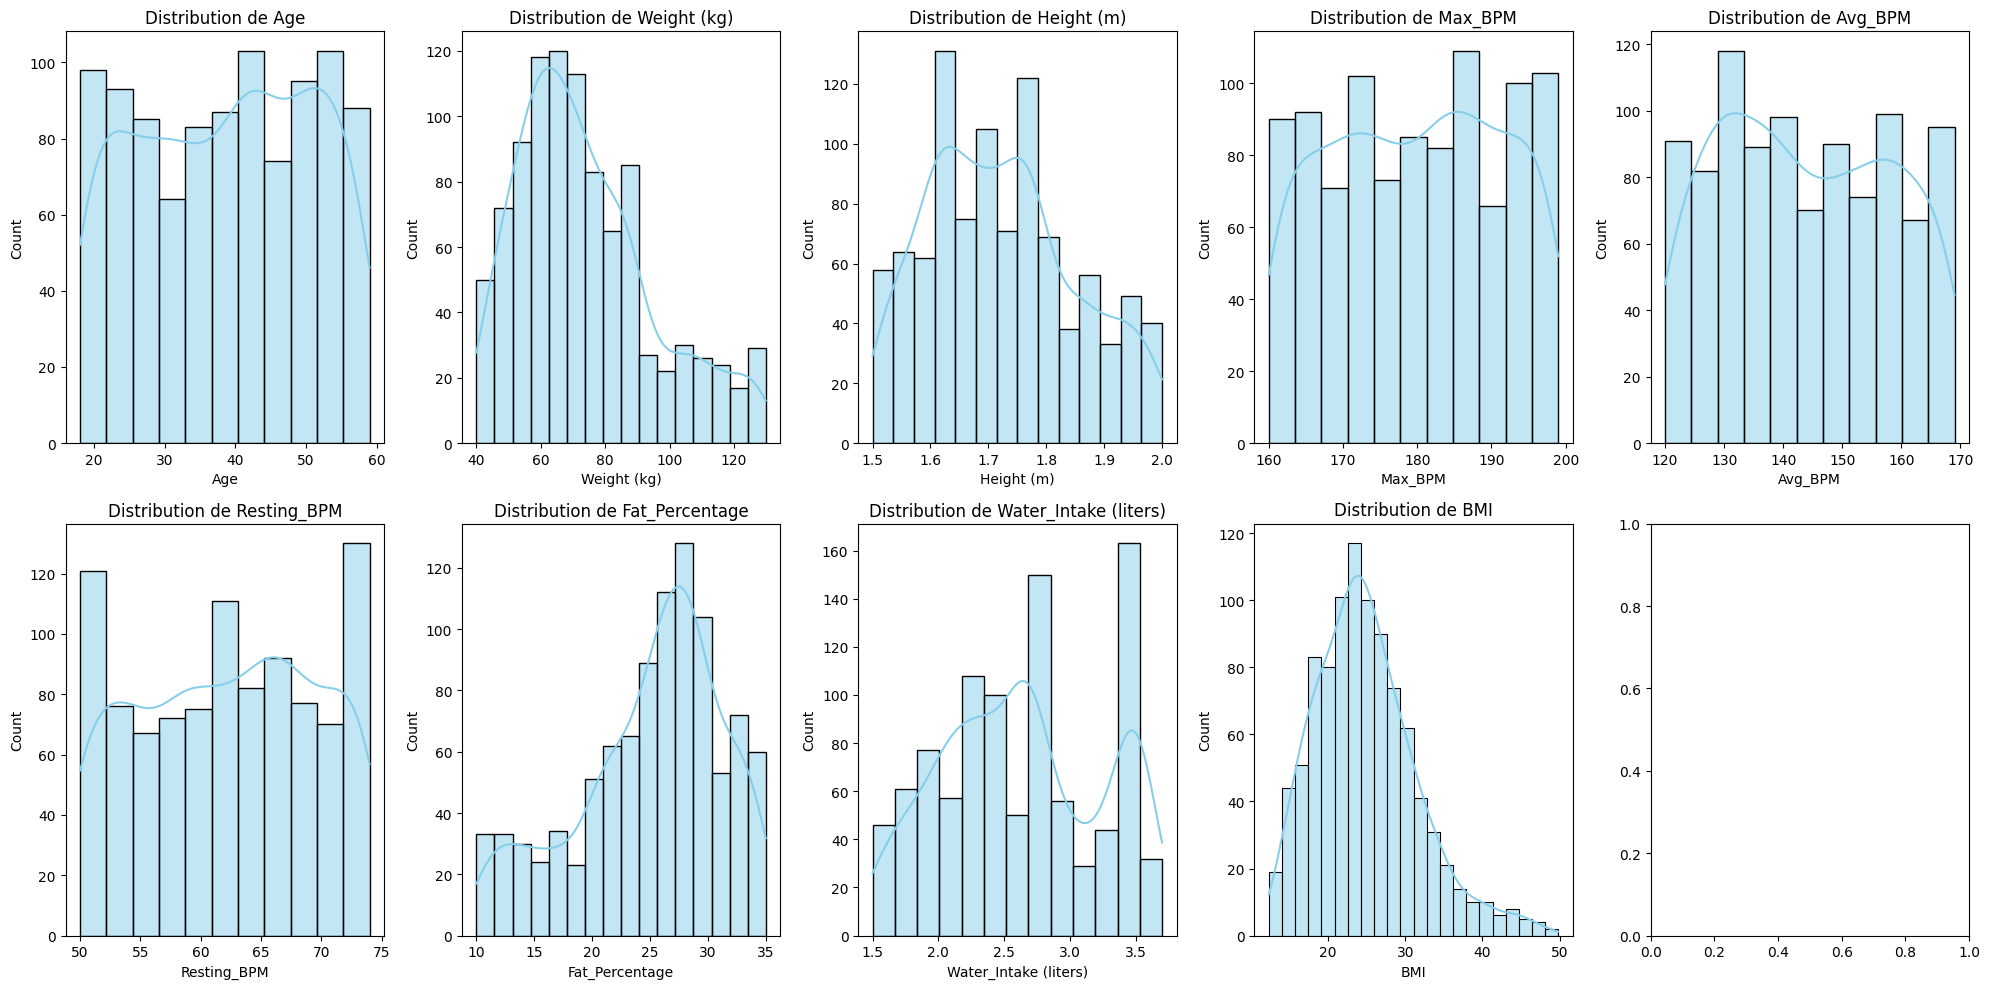

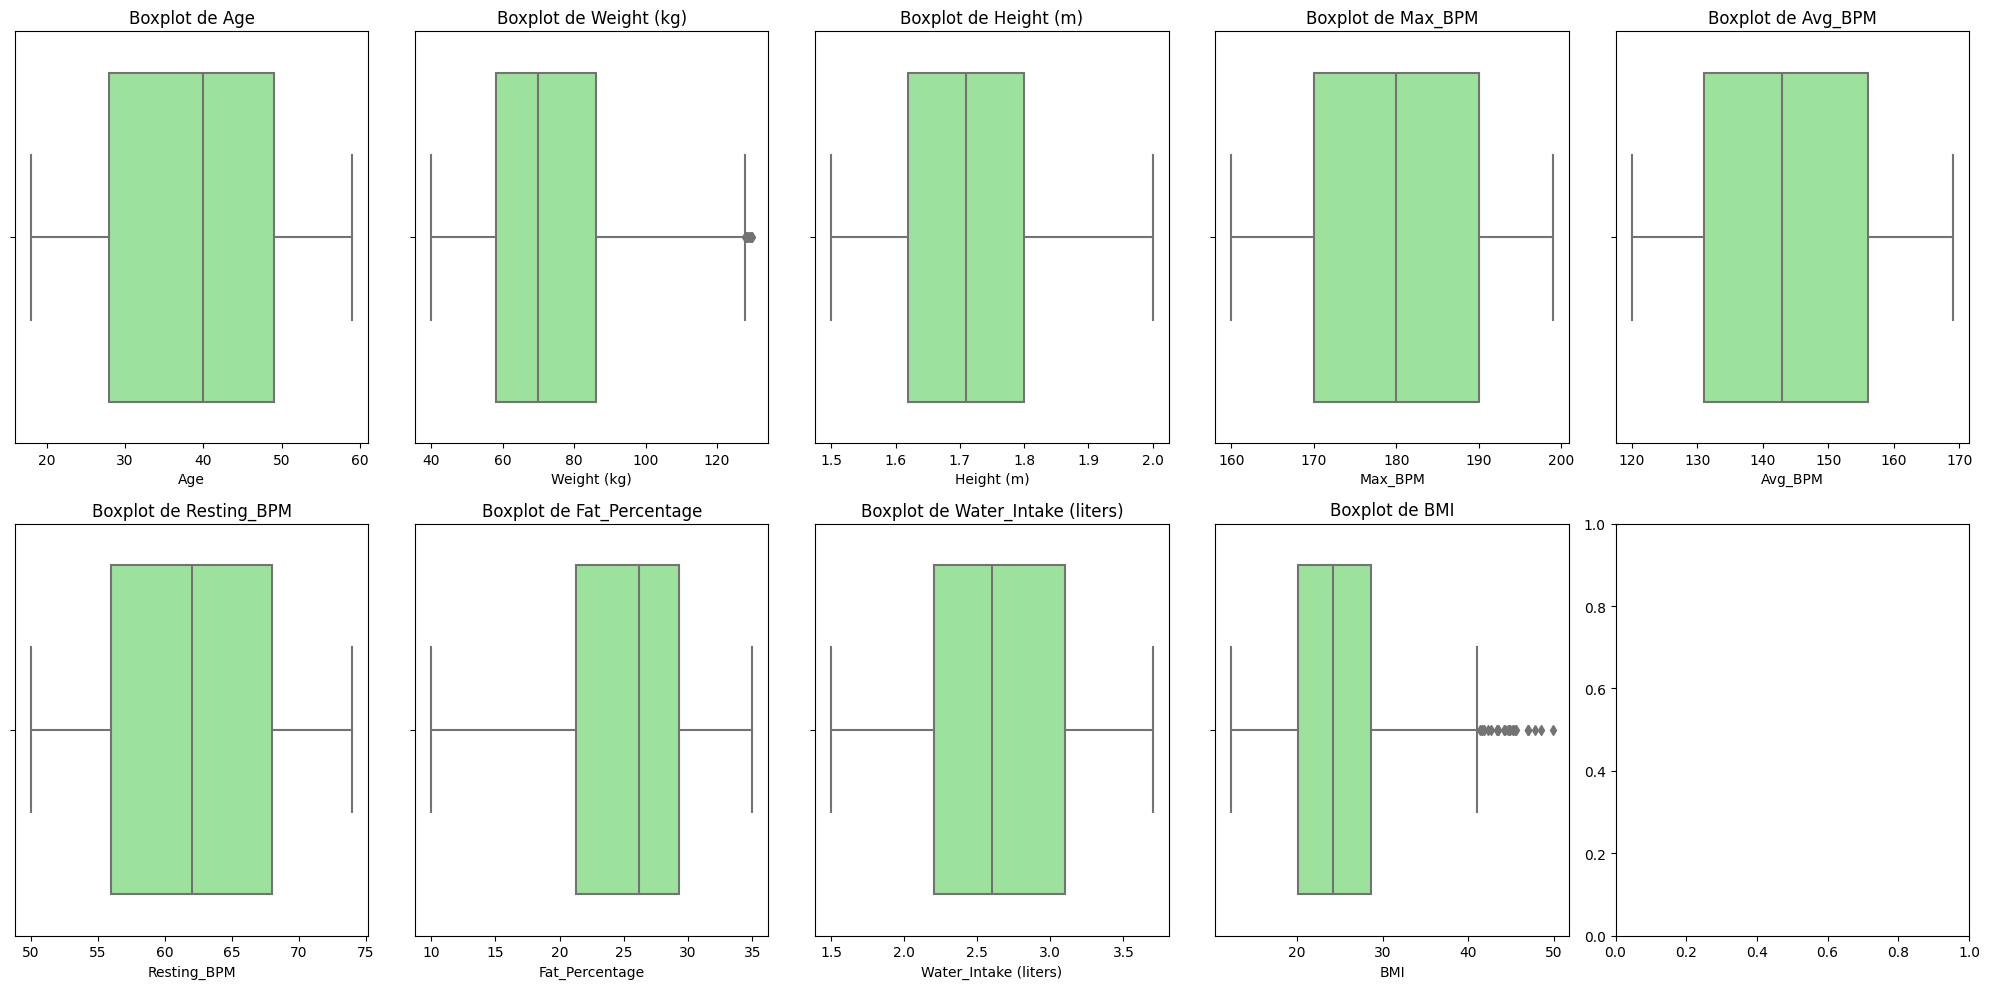

In [72]:
# Étape 1 : Préparation et filtrage des données

# Séparation des variables explicatives et de la cible
X = df.drop(columns=['Calories_Burned'])
y = df['Calories_Burned']

# Standardisation des variables explicatives
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 1. Histogrammes et boxplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(X.columns):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(X.columns):
    sns.boxplot(x=df[col], ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

# Standardisation des données

Nous avons ensuite décidé de baser notre régression linéaire sur l'attribut "Calories_Burned" soit le nombre de calories moyens brûlés en fonction d'autres variables de ce dataset.
Nous avons tout d'abord séparé la variable cible des variables explicatives, que nous avons standardisé afin de faciliter la régression linéaire et de ne pas rencontrer de problèmes d'échelles (entre les différentes variables) et ne pas avoir de coefficients du modèle biaisés.

Nous avons également procédé à l'affichage de plots pour repérer de potentiels outliers (valeurs aberrantes), de visualiser la dispersion des données ou des différences de distribution entre variables. À cette étape du code, nous avons compris la nature des données, procédé à un nettoyage de celles-ci ainsi qu'à leur standardisation.

Ensuite, nous avons créé et ajusté un modèle de régression linéaire multiple entre notre variable cible Calories_Burned et les autres variables continues. Nous avons également obtenu un résumé statistique détaillé : R² a une valeur de 50.4%, le modèle explique donc 50,4% de la variabilité de Calories_Burned, ce qui est modérément bon. La F-statistic est de 108.6, le modèle est donc significatif et on en conclut qu'au moins une variable a un effet sur Calories_Burned. Nous avons également déterminé les principaux pédicteurs, à savoir les variables significatives (Age, Avg_BPM, Fat_Percentage, Water_Intake) et les non-significatives (Weight, Height, Max_BPM, Resting_BPM, BMI). Le fait qu'une variable ait une p-value élevée dans un modèle multivarié ne signifie pas nécessairement qu'elle est inutile. Celles-ci n'ont pas d'effet net détecté mais qui pourraient avoir un effet via la colinéarité ou la suppression d'autres variables

# 1er Modèle de Régression Linéaire 
## Modèle de Régression Multiple Complète

In [73]:
### modele FULL
# 3. Standardize the continuous data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=continuous_vars)

# 4. Define features and target
X = df_scaled.drop(columns=["Calories_Burned"])  # Features
y = df_scaled["Calories_Burned"]                 # Target

# 5. Add constant and fit the model
X = sm.add_constant(X)
modele_full = sm.OLS(y, X).fit()

# 6. Display the model summary
print(modele_full.summary())



                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     108.6
Date:                Tue, 20 May 2025   Prob (F-statistic):          6.38e-140
Time:                        20:27:19   Log-Likelihood:                -1039.8
No. Observations:                 973   AIC:                             2100.
Df Residuals:                     963   BIC:                             2148.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  9.888e-

F-statistic: 108.6
Prob (F-statistic): 6.38e-140 <<<0.05
On rejette l'hypothèse nulle → au moins une variable a un effet significatif sur le nombre de calories brûlées.

D’après les p-values individuelles :

variables non-significatives
- Weight (kg) 0.777
- Height (m) 0.589   
- Max_BPM 0.728  
- Avg_BPM 0.3427  
- Resting_BPM 0.492   
- BMI 0.986                     

Cela signifie que en présence des autres variables (Age, Avg_BPM, Fat_Percentage, BMI), ces variables n’ont pas d'effet significatif sur Calories_Burned.

Le fait qu'une variable ait une p-value élevée dans un modèle multivarié ne signifie pas nécessairement qu'elle est inutile. Elle peut :
- être utile en interaction avec une autre,
- devenir significative si certaines variables sont retirées (problèmes de colinéarité),
- contribuer à améliorer la prédiction globale même si elle n'est pas significative seule.

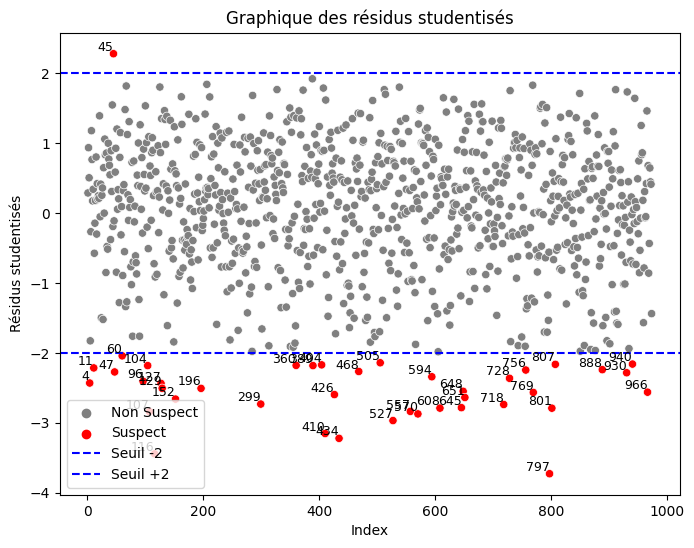

In [74]:
modele1 = modele_full

# 1. Compute Studentized Residuals
residu_student = modele1.get_influence().resid_studentized_internal

# 2. Create DataFrame
df_residus = pd.DataFrame({"residu": residu_student})

# Number of observations
n = len(df["Calories_Burned"])

# 3. Identify Observations with |Residual| > 2 (Potential Outliers)
IDval_ab = np.where(np.abs(df_residus["residu"]) > 2)[0] + 1  # Convert to 1-based index

# 4. Add Identifier Column for Outliers
df_residus["ID"] = ""
df_residus.loc[IDval_ab - 1, "ID"] = IDval_ab  # Adjust back to 0-based index

# 5. Assign Groups Based on Residuals
df_residus["group"] = "Non Suspect"
df_residus.loc[IDval_ab - 1, "group"] = "Suspect"

# 6. Plot Studentized Residuals
plt.figure(figsize=(8, 6))

# Scatter plot with color for groups
sns.scatterplot(x=np.arange(1, n + 1), y=df_residus["residu"], hue=df_residus["group"], palette={"Non Suspect": "gray", "Suspect": "red"})

# Add threshold lines at ±2
plt.axhline(y=-2, color="blue", linestyle="dashed", label="Seuil -2")
plt.axhline(y=2, color="blue", linestyle="dashed", label="Seuil +2")

# 7. Add Labels for Outliers
for i, txt in enumerate(df_residus["ID"]):
    if txt:  # Only label outliers
        plt.text(i + 1, df_residus["residu"].iloc[i], s=txt, fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# Labels and title
plt.xlabel("Index")
plt.ylabel("Résidus studentisés")
plt.title("Graphique des résidus studentisés")

# Add legend
plt.legend()

# Show plot
plt.show()

# Détection des valeurs manquantes/outliers

La prochaine étape a été de détecter et visualiser les valeurs atypiques (aussi appelées "outliers") en se basant sur les résidus studentisés du modèle de régression linéaire. On a ainsi extrait les résidus studentisés internes du modèle que l'on a normalisé pour tenir compte de la variance estimée. En visualisant le DataFrame des résidus, nous avons pu identifier les indices des observations dont le résidu est > 2 ou < -2.
Il s'agit de points suspects qui pourraient déstabiliser ou biaiser le modèle en faussant les coefficient ou en cachant une erreur de saisie ou de mesure.
On constate que le modèle explique raisonnablement bien les données pour la grande majorité des observations puisque les résidus se trouvent globalement dans la zone [-2;+2]. Ainsi, seulement 4 % de nos données sont identifiées comme potentiellement aberrantes.

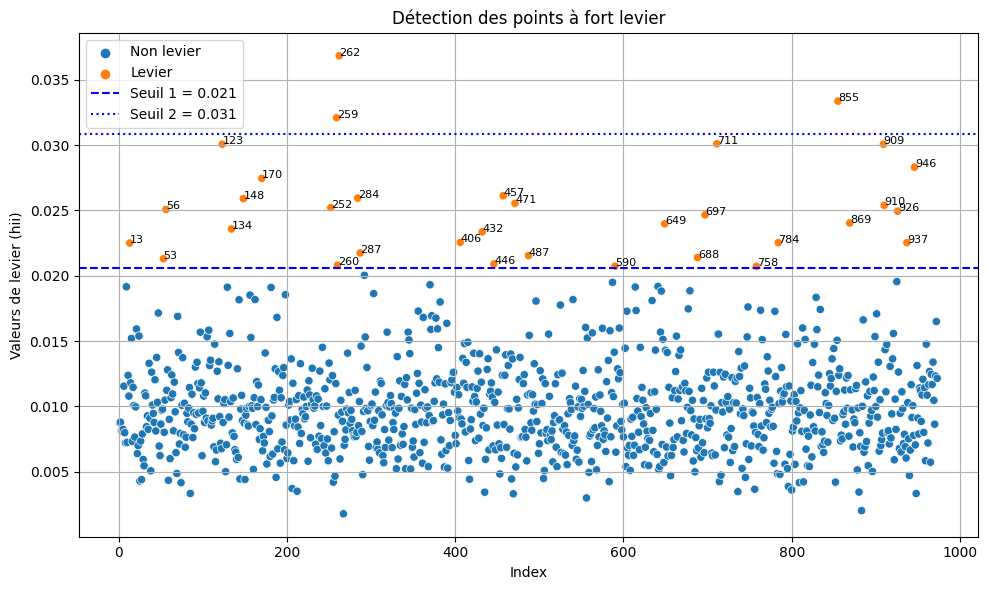

In [77]:
modele1 = modele_full
# 6. Valeurs de levier (hii)
influence = modele1.get_influence()
hat_values = influence.hat_matrix_diag
n = len(hat_values)
p = modele1.df_model + 1  # +1 pour l'intercept

# 7. Seuils
seuil1 = 2 * p / n
seuil2 = 3 * p / n

# 8. Préparer DataFrame
df_H = pd.DataFrame({
    'Index': range(1, n + 1),
    'hii': hat_values,
    'ID': '',
    'group': 'Non levier'
})

# 9. Marquer les points au-delà du seuil
df_H.loc[df_H['hii'] > seuil1, 'ID'] = df_H['Index']
df_H.loc[df_H['hii'] > seuil1, 'group'] = 'Levier'

# 10. Tracer
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_H, x='Index', y='hii', hue='group')
plt.axhline(y=seuil1, color='blue', linestyle='--', label=f'Seuil 1 = {seuil1:.3f}')
plt.axhline(y=seuil2, color='blue', linestyle=':', label=f'Seuil 2 = {seuil2:.3f}')

# Affichage des étiquettes
for _, row in df_H[df_H['group'] == 'Levier'].iterrows():
    plt.text(row['Index'] + 0.3, row['hii'], str(int(row['ID'])), fontsize=8)

plt.xlabel('Index')
plt.ylabel('Valeurs de levier (hii)')
plt.title('Détection des points à fort levier')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Nous avons également cherché à détecter les points leviers qui mesurent à quel point une observation est extrême dans l’espace des variables explicatives.
D'après nos graphiques, le jeu de données contient 3 valeurs aberrantes (au-dessus du seuil 2) et 30 points leviers (compris entre les deux seuils) qui ne représentent qu'une petite partie de notre dataset.

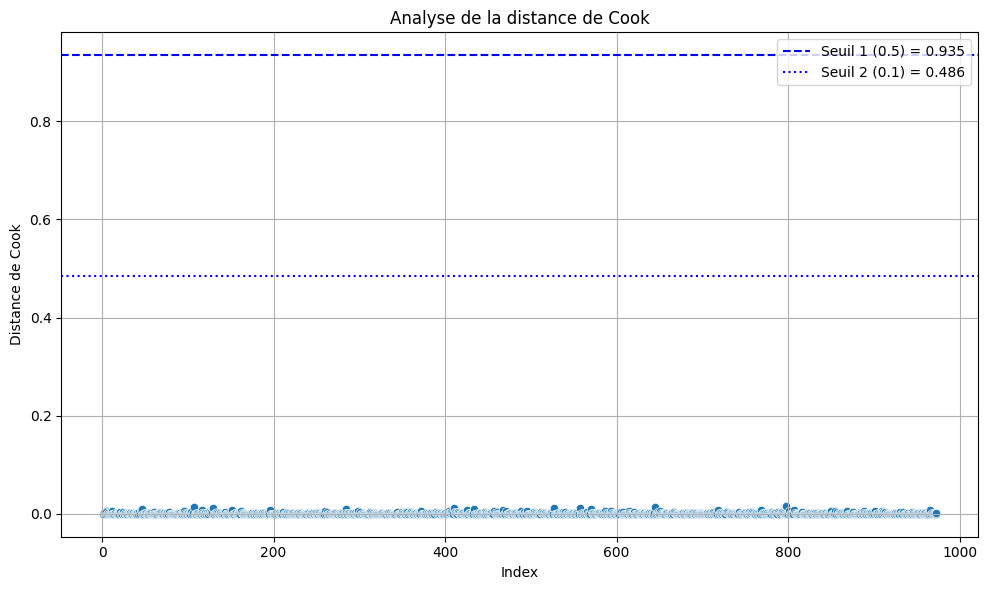

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


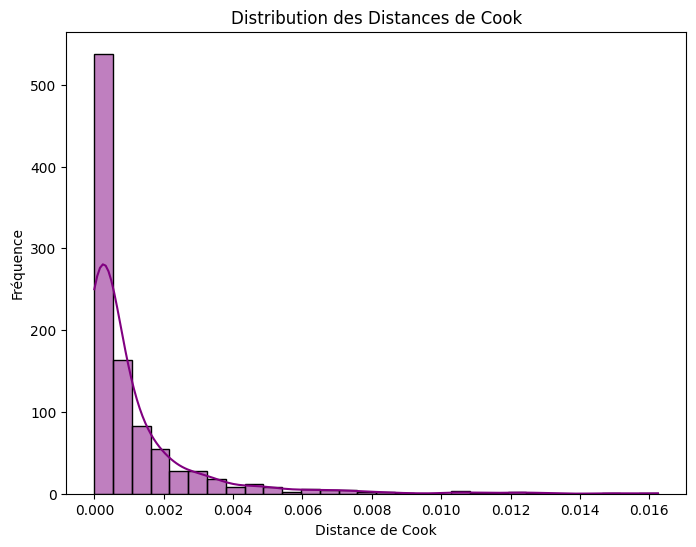

In [78]:

# 1. Distance de Cook
influence = modele1.get_influence()
cooks_d = influence.cooks_distance[0]


# 2. Taille de l’échantillon et degrés de liberté
n = len(cooks_d)
p = int(modele1.df_model + 1)  # +1 pour inclure l'intercept

# 3. Seuils à partir de la loi F
s1 = f.ppf(0.5, p, n - p)
s2 = f.ppf(0.1, p, n - p)

# 4. Création du DataFrame
df_cook = pd.DataFrame({
    'Index': range(1, n + 1),
    'Cook': cooks_d
})

# 5. Tracé avec seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cook, x='Index', y='Cook')
plt.axhline(y=s1, color='blue', linestyle='--', label=f'Seuil 1 (0.5) = {s1:.3f}')
plt.axhline(y=s2, color='blue', linestyle=':', label=f'Seuil 2 (0.1) = {s2:.3f}')
plt.xlabel('Index')
plt.ylabel('Distance de Cook')
plt.title('Analyse de la distance de Cook')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution des distances de Cook
plt.figure(figsize=(8, 6))
sns.histplot(cooks_d, bins=30, kde=True, color='purple')
plt.title("Distribution des Distances de Cook")
plt.xlabel("Distance de Cook")
plt.ylabel("Fréquence")
plt.show()

On remarque cependant qu'aucun point ne possède de distance de Cook élevée (même au-dessus du seuil acceptable).
De plus le qqplot des résidus studendisées contre les quantiles d'une loi de Student de degrés de liberté n−p−1 semble raisonnable et colle à la courbe linéaire. Ainsi on peut considérer que l'ajustement du modèle est correct bien qu'il puisse être amélioré.

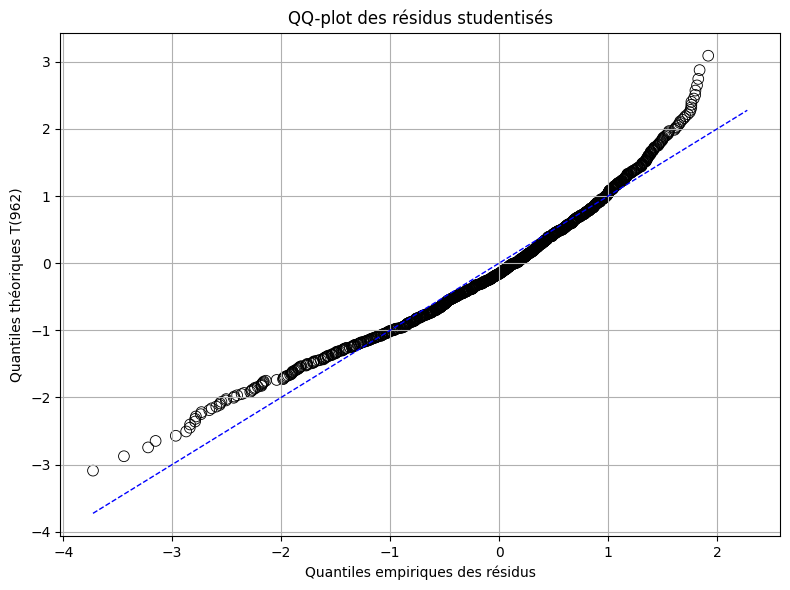

In [79]:
resid_student = modele1.get_influence().resid_studentized_internal
n = len(resid_student)
p = int(modele1.df_model + 1)

# 2. Calcul des quantiles théoriques de Student T(n - p - 1)
quant_t = t.ppf((np.arange(1, n + 1)) / n, df=n - p - 1)

# 3. DataFrame pour le QQ-plot
df_qq = pd.DataFrame({
    'Empirical': np.sort(resid_student),
    'Theoretical': np.sort(quant_t)
})

# 4. QQ-plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_qq, x='Empirical', y='Theoretical', s=60, edgecolor='black', facecolor='none')
plt.plot([df_qq['Empirical'].min(), df_qq['Empirical'].max()],
         [df_qq['Empirical'].min(), df_qq['Empirical'].max()],
         linestyle='--', color='blue', linewidth=1)

plt.xlabel("Quantiles empiriques des résidus")
plt.ylabel(f"Quantiles théoriques T({n - p - 1})")
plt.title("QQ-plot des résidus studentisés")
plt.grid(True)
plt.tight_layout()
plt.show()

ajustement du modèle est correct, mais on pourrait encore l'améliorer

In [80]:
### VIF

# 2. Ajouter une constante (intercept)
X_const = sm.add_constant(X)

# 4. Calculer les VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# 5. Afficher les VIF
print(vif_data)

                Variable        VIF
0                  const   1.000000
1                    Age   1.013537
2            Weight (kg)  71.434503
3             Height (m)  20.492250
4                Max_BPM   1.009721
5                Avg_BPM   1.008028
6            Resting_BPM   1.007329
7         Fat_Percentage   1.534102
8  Water_Intake (liters)   1.850763
9                    BMI  63.950890


Le **VIF** (Variance Inflation Factor) est un outil qui permet de détecter la multicolinéarité, c’est-à-dire, des corrélations trop fortes entre les variables explicatives. Et ce que montre notre tableau de VIF, c’est que les variables ***Weight***, ***Height*** et ***BMI*** sont très redondantes entre elles (*elles sont de fait liées par une relation mathématique*), ce qui est problématique pour le modèle.

En effet, la multicolinéarité n’affecte pas la qualité globale des prédictions (R², etc.), mais rend les coefficients instables et peu interprétables, peut conduire à des p-valeurs trompeuses et rend le modèle sensible à de petites variations dans les données.

Par exemple, comme ***Weight*** et ***BMI*** sont très corrélés, le modèle ne va pas bien savoir "à qui attribuer le mérite" de l’effet : les deux coefficients peuvent sembler peu significatifs ou avoir des signes incohérents.

# 2e Modèle de Régression Linéaire 
## Modèle sans les variables avec un fort VIF

In [81]:
### modele_moins_VIF

# Standardize the continuous data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=continuous_vars)

# 1. Exclure les colonnes avec un fort VIF
cols_to_exclude = ["BMI", "Weight (kg)"] 
df_scaled = df_scaled.drop(columns=cols_to_exclude)
X = df_scaled.drop(columns = ["Calories_Burned"])  # tout sauf cible + exclues
y = df_scaled["Calories_Burned"]  # cible

# 2. Ajouter constante (intercept)
X_const = sm.add_constant(X)

# 3. Ajuster le modèle linéaire
modele_moins_VIF = sm.OLS(y, X_const).fit()

# 4. Résumé du modèle
print(modele_moins_VIF.summary())

### VIF

# 2. Ajouter une constante (intercept)
X_const = sm.add_constant(X)

# 4. Calculer les VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# 5. Afficher les VIF
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     138.8
Date:                Tue, 20 May 2025   Prob (F-statistic):          3.28e-141
Time:                        20:27:23   Log-Likelihood:                -1041.8
No. Observations:                 973   AIC:                             2100.
Df Residuals:                     965   BIC:                             2139.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  9.888e-

**Nouveau modèle :**

***Résultats principaux :***
R² = 0.498, adj_R² = 0.495 : Très proche de l’ancien modèle (0.504), donc pas de perte significative d’explication malgré la suppression de deux variables.

F-statistic = 136.8, p-value ≈ 0 : Le test de Fisher global est significatif, donc le modèle reste globalement pertinent car au moins une variable a un effet significatif sur le nombre de calories brûlées..

***Significativité des coefficients :***
- Significatifs : Age, Avg_BPM, Fat_Percentage (p-value < 0.05)
- Non significatifs : Max_BPM, Resting_BPM, Water_Intake, BMI





# 3e Modèle de Régression Linéaire 
## Modèle Backward Elimination par p-valeur

Pour ce modèle on garde uniquement les variables du modèle 2 dont la **p-valeur** est **inférieur à 0.05**.

On garde ainsi les variables ***Age***, ***Avg_BPM***, ***Fat_Percentage***

In [82]:
### modele_réduit_BE

# Standardize the continuous data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=continuous_vars)

# 1. Exclure deux colonnes (par exemple, colonnes 3 et 4 dans l'esprit de oz[, -c(3,4)])
col_selected = ["Age", "Avg_BPM", "Fat_Percentage"] 
X = df_scaled[col_selected]  # tout sauf cible + exclues
y = df_scaled["Calories_Burned"]  # cible

# 2. Ajouter constante (intercept)
X_const = sm.add_constant(X)

# 3. Ajuster le modèle linéaire
modele_reduit_BE = sm.OLS(y, X_const).fit()

# 4. Résumé du modèle
print(modele_reduit_BE.summary())

### VIF

# 4. Calculer les VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# 5. Afficher les VIF
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     319.1
Date:                Tue, 20 May 2025   Prob (F-statistic):          4.76e-144
Time:                        20:27:23   Log-Likelihood:                -1046.4
No. Observations:                 973   AIC:                             2101.
Df Residuals:                     969   BIC:                             2120.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9.888e-17      0.023   4.34e

# Sélection du modèle

Dans cette partie, on va comparer les performances avec différents critères comme AIC, BIC, R², R² ajusté, MSE, MAE, RMSE

In [83]:
# Avec ce code nous voulons explorer tous les sous-ensembles possibles de variables 
# numériques explicatives de Calories_Burned, afin d’identifier le meilleur compromis 
# entre performance (R², adj. R²) et complexité (AIC, BIC).


# 1. Données : cible et variables explicatives
y = df_scaled['Calories_Burned']

# 2. Garder uniquement les variables numériques pour X
X = df.drop(columns='Calories_Burned')
X = X.select_dtypes(include=[np.number])  # Ne garde que les colonnes numériques

# 3. Paramètre : nombre max de variables
max_features = X.shape[1]
results = []

# 4. Recherche exhaustive sur tous les sous-ensembles
for k in range(1, max_features + 1):
    for subset in itertools.combinations(X.columns, k):
        X_subset = sm.add_constant(X[list(subset)])
        model = sm.OLS(y, X_subset).fit()
        results.append({
            'num_features': k,
            'variables': subset,
            'r2': model.rsquared,
            'adj_r2': model.rsquared_adj,
            'aic': model.aic,
            'bic': model.bic
        })

# 5. Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# 6. Meilleurs modèles selon les critères
best_r2 = results_df.groupby('num_features')['r2'].max()
best_adj_r2 = results_df.groupby('num_features')['adj_r2'].max()
best_aic = results_df.groupby('num_features')['aic'].min()
best_bic = results_df.groupby('num_features')['bic'].min()

#best_r2, best_adj_r2, best_aic, best_bic
#results_df

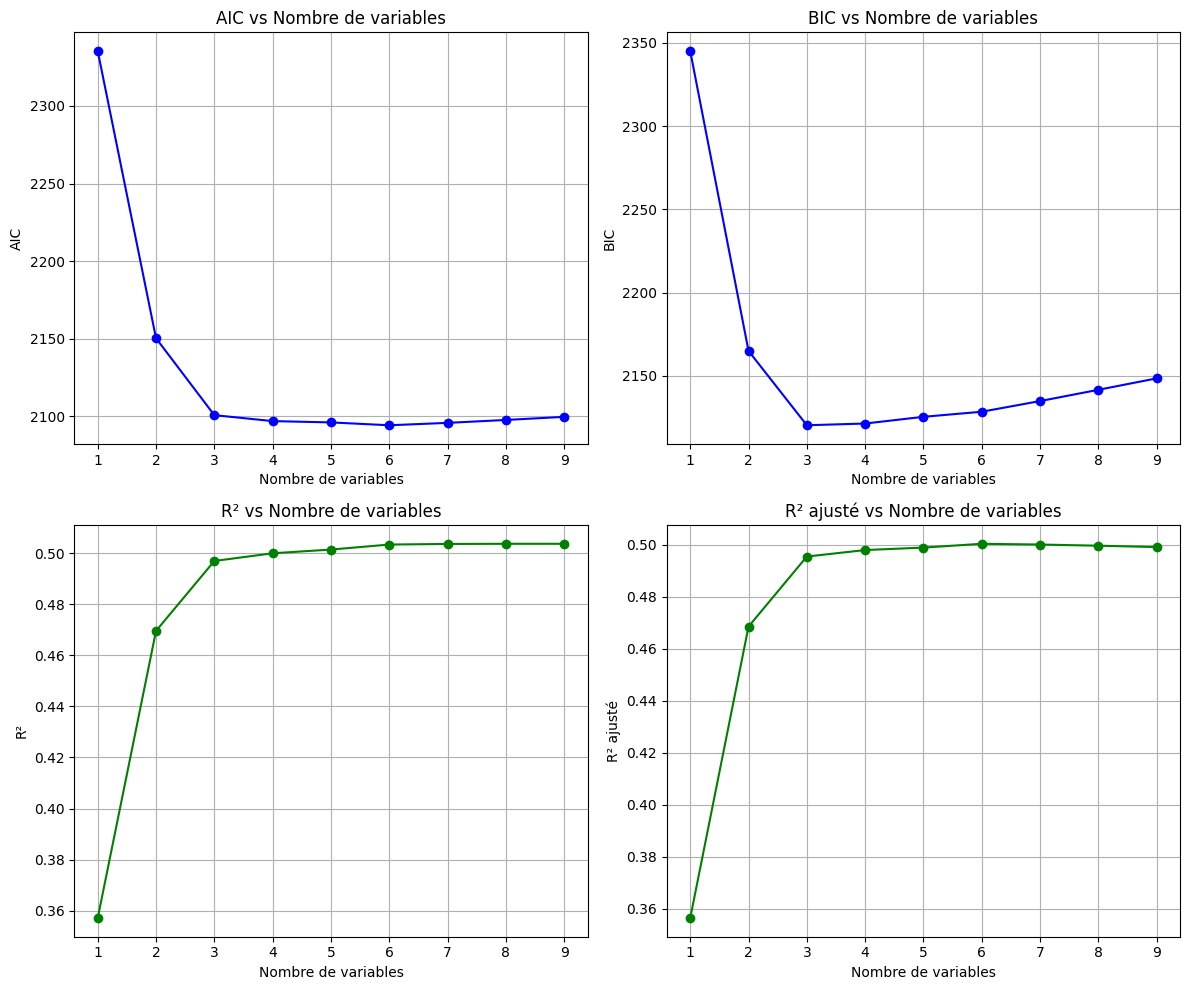

In [84]:
plt.figure(figsize=(12, 10))

# 1. AIC
plt.subplot(2, 2, 1)
plt.plot(best_aic.index, best_aic.values, marker='o', color='blue')
plt.title('AIC vs Nombre de variables')
plt.xlabel('Nombre de variables')
plt.ylabel('AIC')
plt.grid(True)

# 2. BIC
plt.subplot(2, 2, 2)
plt.plot(best_bic.index, best_bic.values, marker='o', color='blue')
plt.title('BIC vs Nombre de variables')
plt.xlabel('Nombre de variables')
plt.ylabel('BIC')
plt.grid(True)

# 3. R²
plt.subplot(2, 2, 3)
plt.plot(best_r2.index, best_r2.values, marker='o', color='green')
plt.title('R² vs Nombre de variables')
plt.xlabel('Nombre de variables')
plt.ylabel('R²')
plt.grid(True)

# 4. R² ajusté
plt.subplot(2, 2, 4)
plt.plot(best_adj_r2.index, best_adj_r2.values, marker='o', color='green')
plt.title('R² ajusté vs Nombre de variables')
plt.xlabel('Nombre de variables')
plt.ylabel('R² ajusté')
plt.grid(True)

plt.tight_layout()
plt.show()


**Interprétation critique :**
***Performances maximales***
- **R²** maximal = 0.5037 atteint avec 8 ou 9 variables mais ce gain est marginal par rapport à des modèles plus simples.

- **R² ajusté** maximal = 0.5003 avec 6 variables, ce qui indique que l’ajout de variables au-delà de 6 n’apporte plus d'amélioration nette.

***Critères de sélection de modèle (AIC / BIC)***
- **Meilleur AIC** : modèle à 6 variables : 2094.24

- **Meilleur BIC** : modèle à 3 variables : 2120.28

Cela indique que le modèle à 3 variables est le plus parcimonieux selon BIC (plus strict).

Un modèle à 4 variables semble être un bon compromis global entre performance et complexité. 

In [85]:
results_df[(results_df["adj_r2"] == best_adj_r2[6]) | (results_df["adj_r2"] == best_adj_r2[3])
            |(results_df["r2"] == best_r2[6]) | (results_df["r2"] == best_r2[3])]

,num_features,variables,r2,adj_r2,aic,bic
64,3,"(Age, Avg_BPM, Fat_Percentage)",0.496942,0.495385,2100.754757,2120.276294
394,6,"(Age, Weight (kg), Height (m), Avg_BPM, Fat_Pe...",0.503372,0.500288,2094.237521,2128.400210


In [86]:
results_df[results_df["bic"]==best_bic[4]]

,num_features,variables,r2,adj_r2,aic,bic
156,4,"(Age, Height (m), Avg_BPM, Fat_Percentage)",0.499952,0.497885,2096.916099,2121.31802


In [87]:
results_df[ (results_df["aic"] == best_aic[4]) ]


,num_features,variables,r2,adj_r2,aic,bic
156,4,"(Age, Height (m), Avg_BPM, Fat_Percentage)",0.499952,0.497885,2096.916099,2121.31802


In [88]:
# 1. Meilleur modèle avec 4 variables selon le BIC
bic_4 = best_bic.loc[4]  # on accède à l'index 4 directement
best_model_bic_4 = results_df[(results_df['num_features'] == 4) & (results_df['bic'] == bic_4)]

# 2. Meilleur modèle avec 4 variables selon le R² ajusté
adj_r2_4 = best_adj_r2.loc[4]
best_model_adjr2_4 = results_df[(results_df['num_features'] == 4) & (results_df['adj_r2'] == adj_r2_4)]

# Affichage
print("🔎 Meilleur modèle (4 variables) selon BIC :")
print(best_model_bic_4)

print("🔎 Meilleur modèle (4 variables) selon R² ajusté :")
print(best_model_adjr2_4)


🔎 Meilleur modèle (4 variables) selon BIC :
     num_features                                   variables        r2  \
156             4  (Age, Height (m), Avg_BPM, Fat_Percentage)  0.499952   

       adj_r2          aic         bic  
156  0.497885  2096.916099  2121.31802  
🔎 Meilleur modèle (4 variables) selon R² ajusté :
     num_features                                   variables        r2  \
156             4  (Age, Height (m), Avg_BPM, Fat_Percentage)  0.499952   

       adj_r2          aic         bic  
156  0.497885  2096.916099  2121.31802  


On constate que le meilleur modèle à 4 variables selon le BIC et le R² ajusté est identique.

Ce modèle est expliqué par 4 variables : **Age**, **Height (m)**, **Avg_BPM**, **Fat_Percentage**

In [89]:
# Méthode 1 : Régression linéaire multiple
modele1 = modele_full

# Méthode 2 : Backward Elimination par p-value
# ne garde que les variables avec une p-valeur inférieure à 0.05
modele2 = modele_reduit_BE

# Méthode 3 : Régression linéaire multiple avec sélection des variables
# selon les critères AIC, BIC, et r²
col_selected = ["Age", "Height (m)", "Avg_BPM", "Fat_Percentage"] 
X = df_scaled[col_selected]  # tout sauf cible + exclues
y = df_scaled["Calories_Burned"]  # cible

X_const = sm.add_constant(X)

modele_select_var = sm.OLS(y, X_const).fit()
modele3 = modele_select_var

# AIC/BIC du modèle complet
aic_1, bic_1 = modele1.aic, modele1.bic
aic_2, bic_2 = modele2.aic, modele2.bic
aic_3, bic_3 = modele3.aic, modele3.aic


# Prédictions

y_pred_1 = modele1.fittedvalues
y_pred_2 = modele2.fittedvalues
y_pred_3 = modele3.fittedvalues

# Fonction de calcul des métriques
def get_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }

# Regroupement des résultats
metrics = {
    "Modèle Complet": get_metrics(y, y_pred_1) | {"AIC": aic_1, "BIC": bic_1},
    "Backward Elimination": get_metrics(y, y_pred_2) | {"AIC": aic_2, "BIC": bic_2},
    "Sélection des variables": get_metrics(y, y_pred_3) | {"AIC": aic_3, "BIC": bic_3}
}

pd.DataFrame(metrics).T.sort_values(by="AIC", na_position="last")


,MSE,RMSE,MAE,R²,AIC,BIC
Sélection des variables,0.500048,0.707141,0.559502,0.499952,2096.916099,2096.916099
Modèle Complet,0.496331,0.704507,0.556900,0.503669,2099.655382,2148.459223
Backward Elimination,0.503058,0.709266,0.560677,0.496942,2100.754757,2120.276294


#### Le ***modèle "Sélection des variables"*** :
- **AIC** & **BIC** les plus bas : critère d'information optimal.

- **R²** pratiquement équivalent aux autres modèles.

- Erreur prédictive très proche du modèle complet (**RMSE** diff. ~0.0026).

*C’est le modèle optimal pour un équilibre entre performance, simplicité et robustesse.*

#### Le ***modèle complet*** :
- Légèrement meilleur **R²**

- Mais **AIC** et **BIC** plus élevés, surtout BIC (pénalise la complexité).

- Moins parcimonieux (trop de variables redondantes ?)

#### ***Backward Elimination*** :
- Moins performant en **AIC**, **BIC**, **RMSE** et **R²**.

- Retire probablement trop de variables utiles.

Le modèle le plus optimal (modèle "sélection des variables") est ici le plus performant. Cependant c'est *un modèle avec un R² ≈ 0.5 signifie que seulement 50 % de la variance de la variable cible (Calories_Burned) est expliquée par les variables indépendantes du modèle. Ce n'est pas mauvais, mais ce n’est pas excellent non plus.*

#### Pourquoi le R² est à 0.5 ? *Hypothèses* :
- Modèle linéaire trop simple : peut-être que les vraies relations sont non linéaires.
- Variables pertinentes manquantes : il manque peut-être des facteurs clés dans ton dataset (ex. activité physique réelle, durée, intensité…).
- Effet d’interactions non modélisé : par ex. l'effet combiné de "Age × Fat_Percentage".
- Erreur de mesure ou bruit important dans les données.

Pour aller plus loin et obtenir un modèle plus performant nous pourrions par exemple tester des modèles non linéaires (arbres de décision, random forest, régressions polynomiales…) ou ajouter d'autres variables/rendre les variables discrètes que nous avons supprimées dès le début continues (nutrition, type d’activité, durée exacte, fréquence cardiaque en continu…).

In [90]:
# Pour modele1 (utilise toutes les variables sauf 'Y')
X_test1 = df_scaled.drop(columns='Calories_Burned', errors='ignore')  # ignore 'Y' if present
X_test1 = sm.add_constant(X_test1, has_constant='add')
Y1 = modele_full.predict(X_test1)

# Pour modele2 (seulement les variables 'Age', 'Height (m)', 'Avg_BPM', 'Fat_Percentage')
X_test2 = df_scaled[['Age', 'Height (m)', 'Avg_BPM', 'Fat_Percentage']]
X_test2 = sm.add_constant(X_test2, has_constant='add')
Y2 = modele_select_var.predict(X_test2)

# 1. Encoder comme pour l'entraînement
X_test1 = df_scaled.drop(columns='Calories_Burned', errors='ignore')
X_test1 = pd.get_dummies(X_test1, drop_first=True).astype(float)

# 2. Ajouter la constante
X_test1 = sm.add_constant(X_test1, has_constant='add')

# 3. Aligner les colonnes avec celles du modèle
X_test1 = X_test1.reindex(columns=modele_full.model.exog_names, fill_value=0)

# 4. Prédiction
Y1 = modele_full.predict(X_test1)

# Modele1 : toutes les variables 
X_train1 = df_scaled.drop(columns='Calories_Burned')
X_train1 = sm.add_constant(X_train1)
modele1 = sm.OLS(y, X_train1).fit()

# Modele2 : variables sélectionnées (par exemple, celles du meilleur modèle à 4 variables)
vars_modele2 = ['Age', 'Height (m)', 'Avg_BPM', 'Fat_Percentage']
X_train2 = sm.add_constant(df_scaled[vars_modele2])
modele2 = sm.OLS(y, X_train2).fit()


In [91]:
# Pour modele1 (utilise toutes les variables sauf 'Y')
X_test1 = df_scaled.drop(columns='Calories_Burned', errors='ignore')  # ignore 'Y' if present
X_test1 = sm.add_constant(X_test1, has_constant='add')
Y1 = modele_full.predict(X_test1)

# Pour modele2 (seulement les variables V2, V3, V5, V8, V9)
X_test2 = df_scaled[['Age', 'Height (m)', 'Avg_BPM', 'Fat_Percentage']]
X_test2 = sm.add_constant(X_test2, has_constant='add')
Y2 = modele_select_var.predict(X_test2)

🔍 Performance du modèle 1 (toutes les variables) :
  ➤ MSE : 0.4963
  ➤ MAE : 0.5569

🔍 Performance du modèle 2 (V2, V3, V5, V8, V9) :
  ➤ MSE : 0.5000
  ➤ MAE : 0.5595


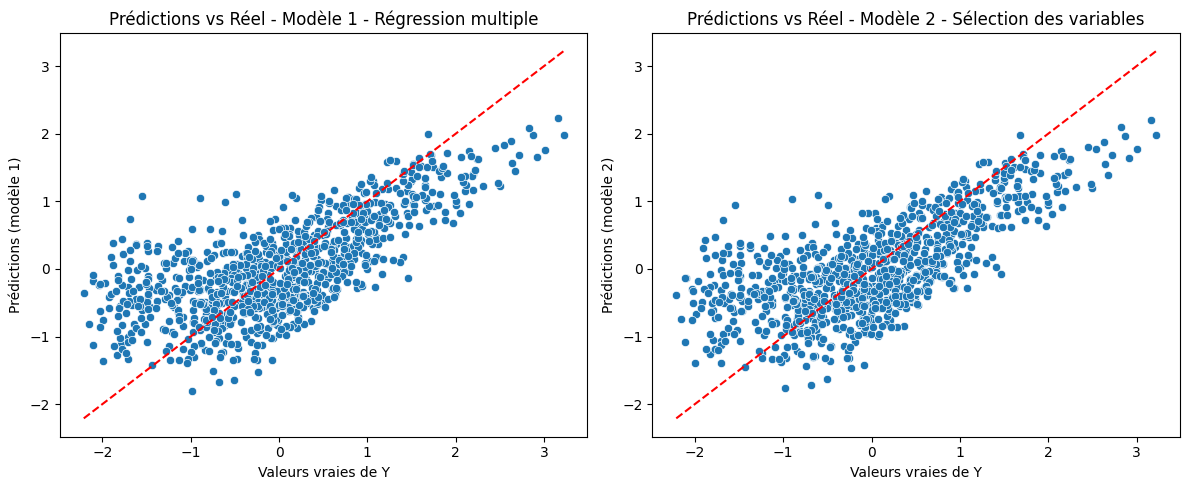

In [92]:
# Assure-toi que la variable vraie 'Y' est bien dans dtest
if 'Calories_Burned' in df_scaled.columns:
    y_true = df_scaled['Calories_Burned']
    
    # MSE et MAE pour modele1
    mse1 = mean_squared_error(y_true, Y1)
    mae1 = mean_absolute_error(y_true, Y1)

    # MSE et MAE pour modele2
    mse2 = mean_squared_error(y_true, Y2)
    mae2 = mean_absolute_error(y_true, Y2)

    print("🔍 Performance du modèle 1 (toutes les variables) :")
    print(f"  ➤ MSE : {mse1:.4f}")
    print(f"  ➤ MAE : {mae1:.4f}")

    print("\n🔍 Performance du modèle 2 (V2, V3, V5, V8, V9) :")
    print(f"  ➤ MSE : {mse2:.4f}")
    print(f"  ➤ MAE : {mae2:.4f}")

    # Visualisation : vraies valeurs vs prédictions
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=Y1)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Valeurs vraies de Y")
    plt.ylabel("Prédictions (modèle 1)")
    plt.title("Prédictions vs Réel - Modèle 1 - Régression multiple")

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_true, y=Y2)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Valeurs vraies de Y")
    plt.ylabel("Prédictions (modèle 2)")
    plt.title("Prédictions vs Réel - Modèle 2 - Sélection des variables")

    plt.tight_layout()
    plt.show()

else:
    print("❗ La colonne 'Y' n'est pas présente dans df_scaled. Impossible de comparer les prédictions aux vraies valeurs.")


#### Erreur quadratique moyenne (MSE)
Le Modèle 1 (la régression multiple complète) a un MSE très légèrement inférieur à celui du Modèle 2 (sélection des variables en fonction de critères (R², AIC, BIC).

Cela indique que sur l’ensemble complet des variables, il y a une légère amélioration de la précision.

Mais l’écart est minime (moins de 0.004) : ce n'est pas significatif en pratique.

#### Erreur absolue moyenne (MAE)
Même constat pour la MAE : écart très faible (moins de 0.003).

Le Modèle 2 est presque aussi bon que le modèle complet, tout en étant beaucoup plus simple et interprétable.

#### Visualisations :
Les nuages de points des prédictions vs vraies valeurs montrent :

- Une bonne tendance linéaire dans les deux cas.

- Une dispersion similaire autour de la diagonale.

*Aucune des deux prédictions ne montre de biais fort ou de dérive, ce qui est un bon signe de généralisation.*

Les modèles ayant des résultats très similaires, nous aurons tendance à choisir le ***modèle 2 de sélection des variables*** pour sa simplicité.

# Validation croisée (k-fold)


In [93]:
# Préparation pour validation croisée
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Pipeline standardisation + régression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Scores négatifs pour MSE et MAE donc on les inverse après
r2_scores = cross_val_score(pipeline_lr, X, y, cv=kf, scoring='r2')
mse_scores = -cross_val_score(pipeline_lr, X, y, cv=kf, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(pipeline_lr, X, y, cv=kf, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(mse_scores)

# Moyennes
cv_results = {
    "R² moyen": r2_scores.mean(),
    "MSE moyen": mse_scores.mean(),
    "RMSE moyen": rmse_scores.mean(),
    "MAE moyen": mae_scores.mean()
}

cv_results

{'R² moyen': 0.493265531130379,
 'MSE moyen': 0.50492866727726,
 'RMSE moyen': 0.7082070252739834,
 'MAE moyen': 0.5622454859192062}

### Interprétation :
#### R² = 0.493
- En moyenne, le modèle explique 49.3 % de la variance des calories brûlées, sur des données jamais vues.

- C’est relativement stable et cohérent avec le R² observé hors validation croisée (≈ 0.50), ce qui confirme la robustesse du modèle.

#### MSE / RMSE
- RMSE ≈ 0.708 ➝ représente l’écart moyen quadratique entre prédictions et valeurs réelles.

- Comme la variable cible a été standardisée, cela signifie ≈ 0.7 écart-type d'erreur moyenne, ce qui est acceptable mais améliorable.

#### MAE ≈ 0.562
- Moyenne des erreurs absolues (plus robuste que RMSE)

- Interprétation : l’erreur moyenne est d’environ 0.56 écart-type par prédiction




In [94]:
# Extraction du modèle backward elimination déjà entraîné
col_selected = ["Age", "Height (m)", "Avg_BPM", "Fat_Percentage"]
X_selected = df[col_selected]
y = df["Calories_Burned"]

# Réajustement du modèle pour affichage clair
X_selected_const = sm.add_constant(X_selected)
modele_final = sm.OLS(y, X_selected_const).fit()

# Coefficients
modele_final.params


const             989.135622
Age                -3.739102
Height (m)       -120.561905
Avg_BPM             6.469479
Fat_Percentage    -26.484206
dtype: float64

### Équation de prédiction des calories brûlées :

**Calories_Burned = 989.14 − 3.74⋅Age − 120.56⋅Height (m) + 6.47⋅Avg_BPM − 26.48⋅Fat_Percentage**

### Interprétation des coefficients :

#### intercept : const = 989.14 :

C’est le nombre de calories prédites pour un individu ayant toutes les variables explicatives égales à 0. Ce n’est pas très interprétable ici, car une personne avec 0 ans, 0 mètre de taille, 0 BPM et 0 % de masse grasse… n’existe pas... Mais l’intercept est nécessaire pour ajuster l’équation.

#### Age (-3.74) :
Chaque année de plus fait baisser les calories brûlées d'environ 3.74, toutes choses égales par ailleurs.

#### Height (m) (-120.56) :
Chaque mètre supplémentaire de taille est associé à une baisse d'environ 120.56 calories brûlées, toutes choses égales par ailleurs.

*Cette valeur semble contre-intuitive : il est possible qu’il y ait une corrélation avec d'autres variables (multicolinéarité) qui perturbe l'interprétation. À analyser via la matrice de corrélation ou le VIF (Variance Inflation Factor).*

#### Avg_BPM (+6.47) :
Chaque battement par minute supplémentaire en moyenne est associé à une augmentation d'environ 6.47 calories brûlées.

*Très intuitif : plus l’intensité cardiaque est élevée, plus on brûle de calories.*

#### Fat_Percentage (-26.48) :
Chaque point de pourcentage de masse grasse supplémentaire est associé à ~26.5 calories brûlées en moins.

*Cela peut s’expliquer par un métabolisme de repos plus faible chez les personnes avec plus de masse grasse.*

# Conclusion

Le modèle est relativement stable et généralisable mais près de 50 % de la variance reste inexpliquée. 

Les raisons à cela pourraient être les suivantes :
- Modèle linéaire trop simple : peut-être que les vraies relations sont non linéaires.
- Variables pertinentes manquantes : il manque peut-être des facteurs clés dans ton dataset (ex. activité physique réelle, durée, intensité…).
- Effet d’interactions non modélisé : par ex. l'effet combiné de "Age × Fat_Percentage".
- Erreur de mesure ou bruit important dans les données.

Pour aller plus loin et obtenir un modèle plus performant nous pourrions par exemple tester des modèles non linéaires (arbres de décision, random forest, régressions polynomiales…) ou ajouter d'autres variables/rendre les variables discrètes que nous avons supprimées dès le début continues (nutrition, type d’activité, durée exacte, fréquence cardiaque en continu…).